# Practical Analysis of the HHL Quantum Linear Solver: Implementation, Circuit Complexity, and Empirical Validation in the NISQ Era

## Packages Gathering

Our work will mainly used the elements from qiskit library

In [ ]:
!pip install -q qiskit qiskit-ibm-runtime qiskit_aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.circuit.library import UnitaryGate, QFTGate
from qiskit.providers.backend import BackendV2, Backend
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt
from collections import Counter
from scipy.linalg import expm

import pandas as pd
import numpy as np

## The problem involved

This project will focus in linear system problems (LSP). These are systems of shape:

$$A \vec{x} = \vec{b}$$

where A is an $N \times N$ matrix and $\vec{b}$ is a vector of coefficients.

Trying to solve a linear system problem (LSP) has become an interesting task in the lastest years. Most common classical algorithms perform with $O(N^3)$ being $N$ the number of equations in the system.

We will study and analyze the HHL algorithm. A quantum-based solution that uses different concepts for solving the LSP problem

### Considerations



For using HLL, we must have an Hermitian matrix $A$. This means that $A = A^{\dagger}$.

This limitation can be overcome using matricial operation techniques. For this implementation, we will focus on using only Hermitian matrices.

Also, the representsation in qubits needs that $N = 2^{n_b}$. So for practicity we will ensure this property

In [ ]:
def is_Hermitian(A, tol=1e-10):
    return np.allclose(A, A.conj().T, atol=tol)

def is_Power_of_2(n):
    if n <= 0:
        return False
    return np.log2(n) % 1 == 0

## Understanding HLL algorithm.

HLL algorithm uses 5 main phases in order to solve LSP. These are:

1. **State Preparation:** Encode the classical vector $b$ into a quantum state $|b\rangle$.

2. **Quantum Phase Estimation (QPE):** Find the eigenvalues of $A$ by applying QPE on $|b\rangle$ using the unitary $e^{iAt}$.

3. **Controlled Rotation (Ancilla Rotation):** Rotate an ancilla qubit inversely proportional to the eigenvalues to encode $A^{-1}$.

4. **Inverse QPE (IQPE):** Uncompute the eigenval

In order to develop our implementation, we will go through each of the phases.


### 1. State preparation

The first step of HHL involves encoding the classical vector $b$ into a quantum state $|b\rangle$. This requires creating a superposition over the computational basis states such that the amplitude of each basis state corresponds to the components of $b$. Efficient state preparation is crucial because the complexity of HHL can depend heavily on how easily $|b\rangle$ can be constructed, and in practical applications, this often involves approximate techniques or ancillary qubits to implement the required amplitudes.


In [ ]:
def prepare_state(c: int, b: np.array) -> QuantumCircuit:
  '''
  Initializes registers for HLL algorithm

  Args:
    c: int           Number of qubits used for clock register
    b: np.array      Coefficients vector for the system

  returns:
    QuamtumCircuit   Prepare State circuit filled with registers and b
    tuple            Registers for further operations
  '''
  # Define registers for phases
  ancilla = QuantumRegister(1, 'a')
  c_register = QuantumRegister(c, 'c')
  b_register = QuantumRegister(int(np.log2(len(b))), 'b')
  classical_ancilla = ClassicalRegister(1, 'c_a')
  classical_b = ClassicalRegister(len(b_register), 'c_b')
  registers = (ancilla, c_register, b_register, classical_ancilla, classical_b)

  # State preparation: Register b is initialized with b vector,
  # register c and ancilla are intialized with zero
  qc = QuantumCircuit(ancilla, c_register, b_register)
  b_norm = b / np.linalg.norm(b)
  qc.initialize(b_norm, b_register)
  qc.add_register(classical_ancilla)
  qc.add_register(classical_b)

  return qc, registers

We can see the result in a simple 3 qubits example circuit. (b register will use $\log_2N$ qubits)

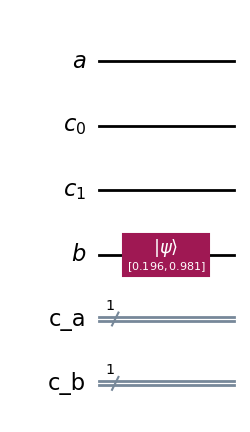

In [ ]:
b = np.array([1,5])
c = 2
qc, _ = prepare_state(c, b)
qc.draw('mpl')

### 2. Quantum Phase Estimation


Quantum Phase Estimation is used to find the eigenvalues of the Hermitian matrix $A$. By applying the unitary $U = e^{iAt}$ to the state $|b\rangle$ along with a set of ancilla qubits, QPE encodes the eigenvalues of $A$ into a quantum register. This step effectively transforms the problem from one involving the original matrix $A$ to one where the eigenvalues are accessible in the quantum state, which is essential for performing the inversion of $A$ in the next step.

Quantum Phase Estimation requieres encoding eigenvalues in the control-unitary and a inverse quantum fourier transformation.

In [ ]:
def apply_controlled_rotations(A: np.array, c_register: QuantumRegister,
                               b_register: QuantumRegister) -> QuantumCircuit:
  '''
  Given a matrix and the clock and b registers, the controlled U gates are applied

  Args:
     A: np.array                     Hermitian matrix that describes LSP
     c_register: QuantumRegister     Clock Register from the circuit
     b_register: QuantumRegister     b coefficients Register from the circuit

  Returns:
     QuantumCircuit      Circuit with U_A rotation gates specification
  '''
  sub_qc = QuantumCircuit(c_register, b_register, name='C-$e^{iAt}$')
  lambda_max = np.linalg.norm(A, 2)
  t = 2 * np.pi / lambda_max
  for k, c_qubit in enumerate(c_register):
      U_k = expm(1j * A * t * (2 ** k))
      U_gate = UnitaryGate(U_k, label=rf"$e^{{iAt2^{k}}}$")
      cU = U_gate.control(1)
      sub_qc.append(cU, [c_qubit] + list(b_register))
  return sub_qc

def quantum_phase_estimation(A: np.array, c_register: QuantumRegister, b_register: QuantumRegister,
                             detailed:bool = False) -> QuantumCircuit:
  '''
  Given a matrix and the clock and b registers, QPE is applied

  Args:
     A: np.array                     Hermitian matrix that describes LSP
     c_register: QuantumRegister     Clock Register from the circuit
     b_register: QuantumRegister     b coefficients Register from the circuit
     detailed: bool                  Defines if circuit is returned compressed or not

  Returns:
     QuantumCircuit      Circuit with QPE specification
  '''
  sub_qc = QuantumCircuit(c_register, b_register)
  # Step 1: Apply Hadarmard gates to register c
  sub_qc.h(c_register)
  # Step 2:  Apply Controlled rotations using b_register and c_register
  ctrl_rot_circ = apply_controlled_rotations(A, c_register, b_register)
  if detailed:
    sub_qc.compose(ctrl_rot_circ, qubits=list(c_register) + list(b_register), inplace=True)
  else:
    sub_qc.append(ctrl_rot_circ.to_gate(), list(c_register) + list(b_register))
  # Step 3: Apply IQFT over c_register
  iqft_gate = QFTGate(c).inverse()
  iqft_gate.label = "IQFT"
  sub_qc.append(iqft_gate, c_register)
  return sub_qc


We can see the result in a simple 3 qubits example circuit.

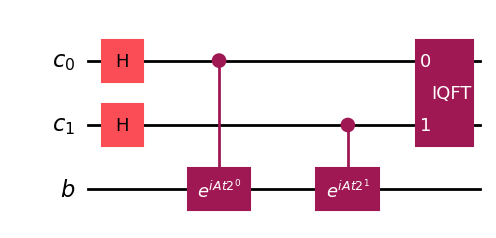

In [ ]:
A = np.eye(2)
b_register = QuantumRegister(1, 'b')
c_register = QuantumRegister(2, 'c')

qc = quantum_phase_estimation(A, c_register, b_register, detailed=True)
qc.draw('mpl')

### 3. Controlled Rotation (Ancilla Rotation)

Once the eigenvalues of $A$ are encoded in a register, a controlled rotation is applied to an ancilla qubit based on these eigenvalues. The rotation angle is inversely proportional to the eigenvalues, effectively encoding $1/\lambda_i$ into the amplitude of the ancilla qubit. This step is the quantum analogue of matrix inversion and is central to obtaining a state proportional to $|x\rangle = A^{-1}|b\rangle$.


In [ ]:
def ancilla_rotation_from_clock(C, c_register, ancilla, name="a-CRy"):
    """
    General ancilla rotation for HHL based on encoded eigenvalues in the clock register.
    Uses CRy gates controlled by individual qubits.

    Args:
        C: float, scaling constant (<= smallest eigenvalue)
        c_register: QuantumRegister (clock register, n qubits)
        ancilla: QuantumRegister (single ancilla qubit)
        name: str, gate name
    Returns:
        QuantumCircuit converted to a Gate
    """
    n = len(c_register)
    sub_qc = QuantumCircuit(ancilla, c_register, name=name)
    for val in range(0, n):
        theta = 2 * np.arcsin(C / (2**val))
        sub_qc.cry(theta, c_register[val], ancilla[0])

    return sub_qc

We can see the result in a simple 4 qubits example circuit.

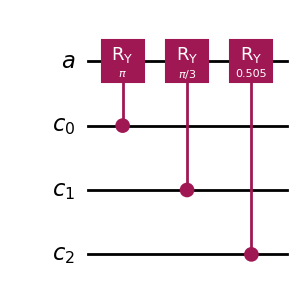

In [ ]:
A = np.eye(2)
ancilla = QuantumRegister(1, 'a')
c_register = QuantumRegister(3, 'c')
C = 1

qc = ancilla_rotation_from_clock(C, c_register, ancilla)
qc.draw('mpl')

### 4. Inverse QPE (IQPE)

After the controlled rotation, the eigenvalue register is no longer needed and must be disentangled from the system qubits. This is done using the inverse Quantum Phase Estimation (IQPE), which reverses the operations of QPE. IQPE ensures that the ancilla qubit contains the correct amplitudes corresponding to $A^{-1}|b\rangle$, while the system qubits are left in a state proportional to the solution $|x\rangle$, ready for measurement or further processing.


In [ ]:
def apply_inverse_controlled_rotations(A: np.array, c_register: QuantumRegister,
                                       b_register: QuantumRegister) -> QuantumCircuit:
  '''
  Given a matrix and the clock and b registers, the inverse controlled U gates
  are applied

  Args:
     A: np.array                     Hermitian matrix that describes LSP
     c_register: QuantumRegister     Clock Register from the circuit
     b_register: QuantumRegister     b coefficients Register from the circuit

  Returns:
     QuantumCircuit      Circuit with U_A rotation gates specification
  '''
  sub_qc = QuantumCircuit(c_register, b_register, name='C-$e^{-iAt}$')
  lambda_max = np.linalg.norm(A, 2)
  t = 2 * np.pi / lambda_max
  for k, c_qubit in reversed(list(enumerate(c_register))):
      U_k = expm(-1j * A * t * (2 ** k))
      U_gate = UnitaryGate(U_k, label=rf"$e^{{-iAt2^{k}}}$")
      cU = U_gate.control(1)
      sub_qc.append(cU, [c_qubit] + list(b_register))
  return sub_qc


def inverse_quantum_phase_estimation(A: np.array, c_register: QuantumRegister,
                                     b_register: QuantumRegister,
                                     detailed:bool = False) -> QuantumCircuit:
  '''
  Given a matrix and the clock and b registers, QPE is applied

  Args:
     A: np.array                     Hermitian matrix that describes LSP
     c_register: QuantumRegister     Clock Register from the circuit
     b_register: QuantumRegister     b coefficients Register from the circuit
     detailed: bool                  Defines if circuit is returned compressed or not

  Returns:
     QuantumCircuit      Circuit with QPE specification
  '''
  sub_qc = QuantumCircuit(c_register, b_register)
  #Step 1: Apply QFT over c_register
  qft_gate = QFTGate(c)
  qft_gate.label = "QFT"
  sub_qc.append(qft_gate, c_register)
  # Step 2:  Apply Controlled rotations using b_register and c_register
  ctrl_rot_circ = apply_inverse_controlled_rotations(A, c_register, b_register)
  if detailed:
    sub_qc.compose(ctrl_rot_circ, qubits=list(c_register) + list(b_register), inplace=True)
  else:
    sub_qc.append(ctrl_rot_circ.to_gate(), list(c_register) + list(b_register))
  # Step 3: Apply Hadarmard gates to register c
  sub_qc.h(c_register)
  return sub_qc

We can see the result in a simple 3 qubits example circuit.

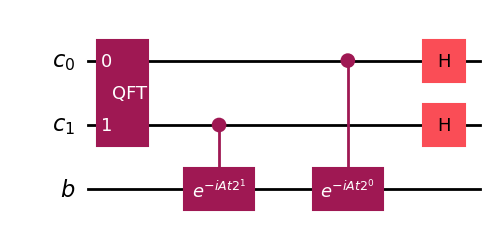

In [ ]:
A = np.eye(2)
b_register = QuantumRegister(1, 'b')
c_register = QuantumRegister(2, 'c')

qc = inverse_quantum_phase_estimation(A, c_register, b_register, detailed=True)
qc.draw('mpl')

### 5. Measurement / Readout




The final step involves measuring the system and/or ancilla qubits to extract information about the solution vector $x$. Direct measurement collapses the state to a computational basis, providing probabilistic samples related to $x$. Alternatively, if $|x\rangle$ is needed for further quantum computation, the state can be used in subsequent algorithms without measurement. This step bridges the quantum solution back to classical information.

In order to apply this schema correctly, we will build the full circuit using a main routine that calls the previous phases

In [ ]:
def build_HHL_Circuit(A: np.array, b: np.array,
                      c:int, C:int=1, detailed:bool=False) -> QuantumCircuit:
  '''
  Builds a HHL circuit for solving the Ax = b problem

  Args:
    A: np.array      Hermitian matrix of the equations coefficients
    b: np.array      Coefficients of right side
    c: int           Number of clock qubits
    C: float         Constant for ancilla rot
    detailed: bool   Defines if circuit is returned compressed or not

  Returns:
    QuantumCircuit   Quantum circuit for Ax=b LSP
  '''
  # Initialize circuit
  qc, (ancilla, c_register, b_register, classical_ancilla, classical_b) = prepare_state(c,b)
  qc.barrier()
  # Apply QPE
  qpe = quantum_phase_estimation(A, c_register, b_register, detailed = detailed)
  qc.compose(qpe, qubits=list(c_register)+list(b_register), inplace=True)
  qc.barrier()
  # Apply U_A rotations
  qua = ancilla_rotation_from_clock(C, c_register, ancilla)
  qc.compose(qua, qubits=list(ancilla)+list(c_register), inplace=True)
  qc.barrier()
  # Apply IQPE
  iqpe = inverse_quantum_phase_estimation(A, c_register, b_register, detailed = detailed)
  qc.compose(iqpe, qubits=list(c_register)+list(b_register), inplace=True)
  qc.barrier()
  # Apply measurements
  qc.measure(ancilla, classical_ancilla)
  qc.measure(b_register, classical_b)
  return qc

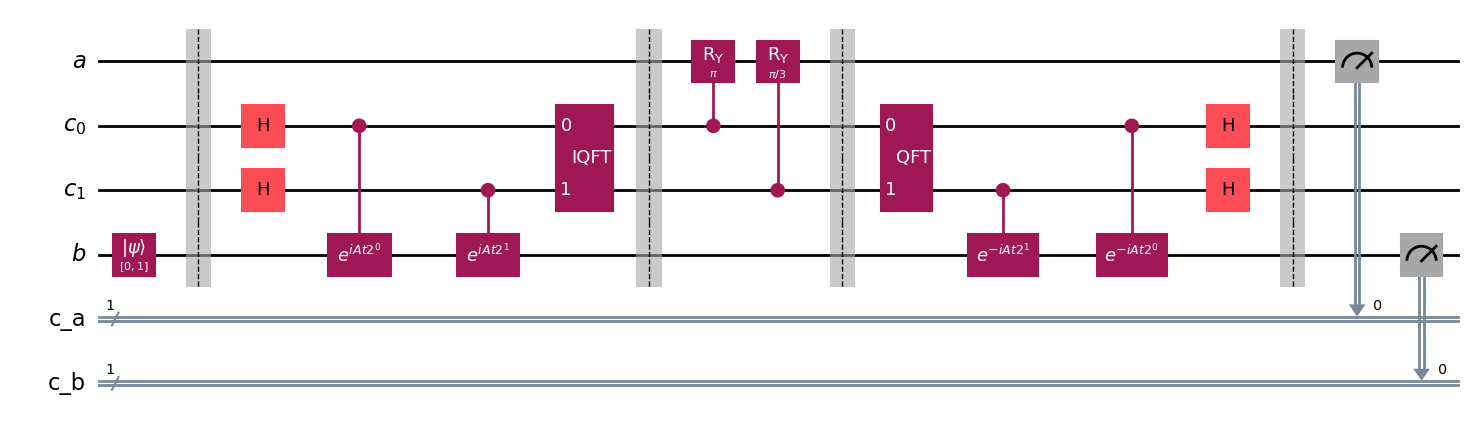

In [ ]:
A = np.eye(2)
b = np.array([0,1])
c = 2
C = 1
qc = build_HHL_Circuit(A,b,c,C,detailed=True)
qc.draw('mpl')

For reading out process, we must define an strategy that takes ancilla values in 1 and retreives counts, probabilities or amplitudes measurements.

In [ ]:
class HLLExperiment:
    """
    A class to manage and analyze experiments related to the HHL (Harrow-Hassidim-Lloyd) quantum algorithm.

    This class allows running a quantum circuit, collecting measurement results, filtering based
    on ancilla qubit states, and computing probabilities and amplitudes of the outcomes. It also
    provides methods to retrieve the solution vector encoded in the measurement results.

    Attributes
    ----------
    qc : QuantumCircuit
        The quantum circuit representing the HHL experiment.
    counts : dict or None
        The measurement results of the quantum circuit, stored as a dictionary of bitstrings and their counts.
    """

    def __init__(self, qc: QuantumCircuit):
        """
        Initializes the HLLExperiment with a given quantum circuit.

        Parameters
        ----------
        qc : QuantumCircuit
            The quantum circuit to run and analyze.
        """
        self.qc = qc
        self.counts = None

    def run(self, shots: int = 1024):
        """
        Executes the quantum circuit on a simulator and stores the measurement counts.

        Parameters
        ----------
        shots : int, optional
            The number of measurement shots to perform (default is 1024).

        Returns
        -------
        self : HLLExperiment
            Returns the instance to allow method chaining.
        """
        sim = AerSimulator()
        compiled_qc = transpile(self.qc, sim)
        result = sim.run(compiled_qc, shots=shots).result()
        self.counts = result.get_counts()
        return self

    def plot(self, title: str = '') -> None:
        """
        Plots a histogram of the measurement results.

        Parameters
        ----------
        title : str, optional
            The title of the histogram (default is empty string).

        Raises
        ------
        ValueError
            If the experiment has not been run yet (i.e., `counts` is None).
        """
        if self.counts is None:
            raise ValueError("Run the experiment first using .run()")
        fig, ax = plt.subplots()
        plot_histogram(self.counts, title=title, ax=ax)
        fig.tight_layout()
        plt.show()

    def filter_ancilla(self, value='1'):
        """
        Filters the measurement results to include only outcomes where the ancilla qubit has the specified value.

        Parameters
        ----------
        value : str, optional
            The target state of the ancilla qubit to filter by (default is '1').

        Returns
        -------
        self : HLLExperiment
            Returns the instance with updated counts.

        Raises
        ------
        ValueError
            If the experiment has not been run yet (i.e., `counts` is None).
        """
        if self.counts is None:
            raise ValueError("Run the experiment first using .run()")
        r = {}
        for key, val in self.counts.items():
            if key[0] == value:
                r[key] = val
        self.counts = r
        return self

    def get_results(self):
        """
        Returns the raw measurement counts.

        Returns
        -------
        dict
            A dictionary mapping measurement bitstrings to their counts.
        """
        return self.counts

    def compute_probs(self):
        """
        Computes normalized probabilities for each measurement outcome.

        Returns
        -------
        dict
            A dictionary mapping measurement bitstrings to their probabilities.
        """
        s = sum(self.counts.values())
        return {a: k/s for a, k in self.counts.items()}

    def compute_amplitudes(self):
        """
        Computes amplitudes (square roots of probabilities) for each measurement outcome.

        Returns
        -------
        dict
            A dictionary mapping measurement bitstrings to their amplitudes.
        """
        s = sum(self.counts.values())
        return {a: (k/s)**0.5 for a, k in self.counts.items()}

    def retreive_answer(self):
        """
        Retrieves the solution vector from the measurement amplitudes, in the order corresponding to the circuit encoding.

        Returns
        -------
        np.ndarray
            The solution vector extracted from the amplitudes of the measurement results.
        """
        s = self.compute_amplitudes()
        n = len(s.keys())
        a = np.zeros(shape=(n,))
        n_bits = int(np.log2(n))
        for i in range(n):
            bitstr = '1 ' + format(i, f'0{n_bits}b')
            a[n-1-i] = s.get(bitstr, 0)
        return a

We see each scenario for retreiving results

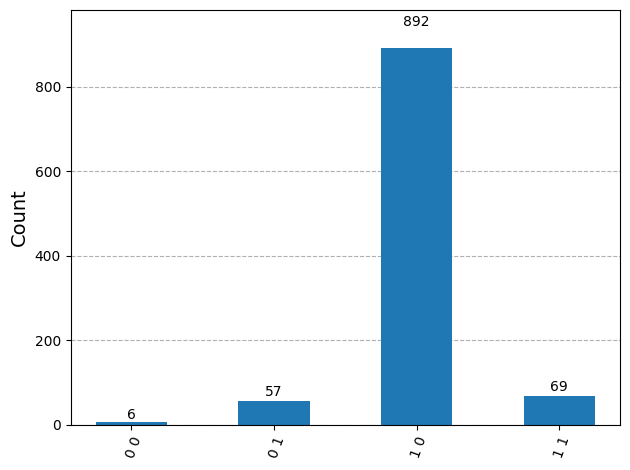


Counts = {'1 1': 69, '0 1': 57, '0 0': 6, '1 0': 892}
Results filtered = {'1 1': 69, '1 0': 892}
Answer retreived = [0.26795561 0.96343126]


In [ ]:
A = np.array([
    [1, -1/3],
    [-1/3, 1]
])
b = np.array([0,1])
c = 2
C = 1
qc = build_HHL_Circuit(A,b,c,C,detailed=True)
sampler = HLLExperiment(qc)
sampler.run()
sampler.plot()
print(f'\nCounts = {sampler.get_results()}')
print(f'Results filtered = {sampler.filter_ancilla().get_results()}')
print(f'Answer retreived = {sampler.retreive_answer()}')


### Considerations

As we said before, we must ensure the propertiees for the circuit construction, then we will define a class that encapsulates this behaviour

In [ ]:
class HLLSolver:
    """
    A solver for linear systems using the HHL (Harrow-Hassidim-Lloyd) quantum algorithm.

    This class validates the input matrix and vector, builds the corresponding HHL quantum circuit,
    runs the experiment, and provides methods to retrieve the solution, view a report, and plot
    the circuit.

    Attributes
    ----------
    A : np.array
        The Hermitian matrix representing the coefficients of the linear system.
    b : np.array
        The right-hand side vector of the linear system.
    c : int
        Number of qubits used for phase estimation in the HHL circuit.
    C : float
        Constant parameter used in the HHL circuit for ancilla rotation.
    qc : QuantumCircuit or None
        The built quantum circuit for the HHL experiment.
    sampler : HLLExperiment or None
        The HLLExperiment instance used to run and analyze the circuit.
    report : str or None
        Summary report of the experiment, including raw and filtered results.

    Methods
    -------
    build(detailed: bool)
        Builds the HHL circuit, runs the experiment, and generates a summary report.
    get_answer()
        Returns the solution vector retrieved from the HHL experiment.
    show_report()
        Prints the summary report of the experiment.
    plot_circuit(title: str = 'HLL Circuit')
        Plots the quantum circuit using a large figure for better visibility.
    """

    def __init__(self, A: np.array, b: np.array, c: int, C: float):
        """
        Initializes the HLLSolver with matrix A, vector b, and HHL parameters.

        Parameters
        ----------
        A : np.array
            Hermitian square matrix of shape (n, n).
        b : np.array
            Vector of length n.
        c : int
            Number of qubits for phase estimation.
        C : float
            Constant parameter for the HHL ancilla rotation.

        Raises
        ------
        ValueError
            If A is not Hermitian, not square, or if the length of b does not match A.
            Also raises if the size of b is not a power of 2.
        """
        if not is_Hermitian(A):
            raise ValueError('Matrix A is not Hermitian')
        if A.shape[0] != A.shape[1]:
            raise ValueError('Matrix A must be square')
        if len(b) != A.shape[0]:
            raise ValueError('A and b does not match')
        if not is_Power_of_2(len(b)):
            raise ValueError('A and b must be power of 2 shape')

        self.A = A
        self.b = b
        self.c = c
        self.C = C
        self.qc = None
        self.sampler = None
        self.report = None

    def build(self, detailed: bool):
        """
        Builds the HHL quantum circuit, runs the experiment, and generates a summary report.

        Parameters
        ----------
        detailed : bool
            If True, builds the circuit with detailed gates; otherwise, builds a simplified version.
        """
        self.qc = build_HHL_Circuit(self.A, self.b, self.c, detailed=detailed)
        self.sampler = HLLExperiment(self.qc)
        self.sampler.run()
        self.report = f'''
        Results Summary

        QC Output: {self.sampler.get_results()}
        QC filtered (Ancilla=1): {self.sampler.filter_ancilla().get_results()}
        LSP Probabilities: {self.sampler.filter_ancilla().compute_probs()}
        LSP result: {self.sampler.filter_ancilla().retreive_answer()}
        '''
        return self

    def get_answer(self):
        """
        Retrieves the solution vector from the HHL experiment.

        Returns
        -------
        np.ndarray
            Solution vector obtained from the measurement amplitudes.
        """
        return self.sampler.retreive_answer()

    def show_report(self):
        """
        Prints the summary report of the HHL experiment, including raw counts,
        filtered ancilla results, probabilities, and the final solution.
        """
        print(self.report)

    def plot_circuit(self, title: str = 'HLL Circuit'):
        """
        Plots the quantum circuit using a large figure for better visibility.

        Parameters
        ----------
        title : str, optional
            Title of the plot (default is 'HLL Circuit').

        Raises
        ------
        ValueError
            If the circuit has not been built yet (i.e., `self.qc` is None).
        """
        if self.qc is None:
            raise ValueError("Build the circuit using .build()")

        n_qubits = self.qc.num_qubits
        fig_height = max(6, n_qubits * 1.5)
        fig, ax = plt.subplots(figsize=(20, fig_height))
        self.qc.draw('mpl', ax=ax)
        ax.set_title(title, fontsize=16)
        fig.tight_layout()
        plt.show()


        Results Summary

        QC Output: {'1 1': 65, '0 1': 73, '0 0': 1, '1 0': 885}
        QC filtered (Ancilla=1): {'1 1': 65, '1 0': 885}
        LSP Probabilities: {'1 1': 0.06842105263157895, '1 0': 0.9315789473684211}
        LSP result: [0.26157418 0.96518337]
        


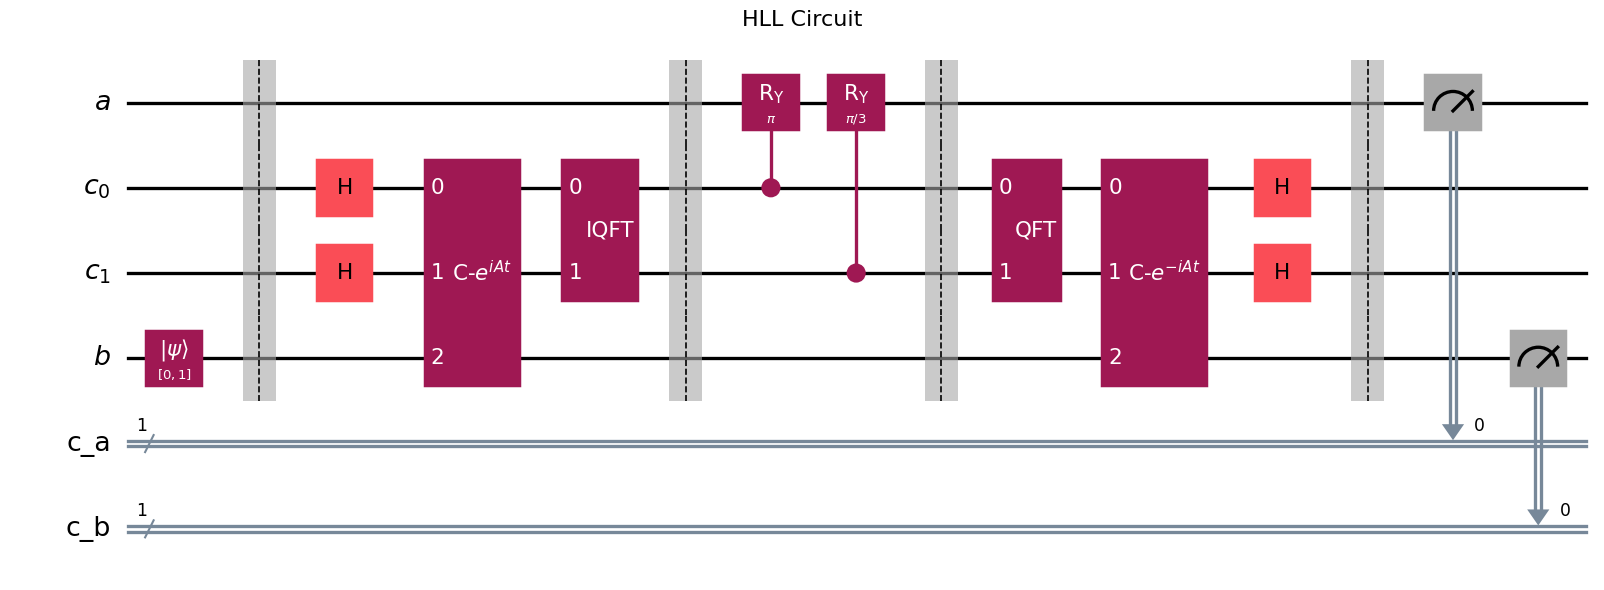

In [ ]:
A = np.array([
    [1, -1/3],
    [-1/3, 1]
])
b = np.array([0,1])
c = 2
C = 1

hll_solver = HLLSolver(A,b,c,C)
hll_solver.build(detailed=False)
hll_solver.show_report()
hll_solver.plot_circuit()

## Solving different size problems

Even if right now it is not feasible to solve large problems due to hardware limitations. We will focus in show what does HLL say the LSP solution, how do we compare it classical solutions and how does this method behaves in those scenarios

### Understanding HLL output

As we saw, the amplitudes encoded in the register $ b $ after applying the circuit contain the solution vector $ \vec{x} $. However, these amplitudes are subject to intrinsic restrictions imposed by the structure of the Hilbert space. In particular:

1. **Normalization constraint**
   $$
   \sum_i |x_i|^2 = 1,
   $$
   since quantum states must be normalized.

2. **Global phase invariance**
   $$
   \vec{x} \sim e^{i\phi}\vec{x},
   $$
   meaning the solution is only defined up to an overall (global) phase, which has no physical significance and cannot be observed.

3. **Loss of absolute scaling**
   $$
   |x \rangle = \frac{\vec{x}}{\|\vec{x}\|},
   $$
   so the HHL algorithm outputs a normalized quantum state. The absolute magnitude of the classical solution is not directly accessible; only relative amplitudes are preserved.

4. **Probabilistic access via measurement**
   
   The components $ x_i $ cannot be read out deterministically. Instead, repeated measurements yield outcome probabilities
   $$
   P(i) = |x_i|^2,
   $$
   from which information about the solution must be inferred statistically.

5. **Post-selection constraint**
   
   The final state $|x \rangle$ is obtained conditionally on a successful measurement of an ancilla qubit, which affects both the normalization and the overall success probability of the algorithm.

These constraints imply that HHL encodes the *direction* of the solution vector in Hilbert space rather than its full classical representation, making it most suitable for applications that rely on expectation values or inner products involving $ \vec{x} $, rather than explicit access to all its components.


We will se this with an example, where:

$$
A = \left(
\begin{matrix}
1 & -1/3 \\
    -1/3 &  1
\end{matrix}  
\right)
$$

$$
b = \left(
\begin{matrix}
0 \\
    1
\end{matrix}  
\right)
$$

We can compute the result using a classical scenario

In [ ]:
A = np.array([
    [1, -1/3],
    [-1/3, 1]
])
b = np.array([0,1])
r_c = np.linalg.inv(A) @ b

r_c

array([0.375, 1.125])

From the solution, we can compute the relationship between the values

In [ ]:
r_c / np.min(r_c)

array([1., 3.])

We can see that there is 3:1 relationship in the answer components. Then we expect to have a similar result in the HLL output

In [ ]:
A = np.array([
    [1, -1/3],
    [-1/3, 1]
])
b = np.array([0,1])
c = 2
C = 1

hll_solver = HLLSolver(A,b,c,C)
hll_solver.build(detailed=False)
hll_solver.show_report()


        Results Summary

        QC Output: {'1 1': 61, '0 1': 49, '0 0': 2, '1 0': 912}
        QC filtered (Ancilla=1): {'1 1': 61, '1 0': 912}
        LSP Probabilities: {'1 1': 0.06269270298047276, '1 0': 0.9373072970195272}
        LSP result: [0.25038511 0.96814632]
        


In [ ]:
r_hll = hll_solver.get_answer()
r_hll / np.min(r_hll)

array([1.        , 3.86662898])

As we can see, HLL returns soem values near to the 3:1 proportion that was  defined in the classical scenario. However, we must say that solution is not as near to the real one as we would like. This phenomena is consequence of the precision given by the clock, with more qubits, we could expect a better performance

## Complexity analysis

In order to make the theoretical analysis of the circuit complexity, we will use two strategies, one related to the nunber of gates and another related to the depth of the circuit. We will use the scenario of the circuit compiled for a hardware and the circuit output generated by our classes

In [ ]:
def build_generic_ibm_backend(
    n_qubits: int,
    topology: str = "line"
):
    """
    Build a generic BackendV2 using a real IBM Quantum native gate set.

    Args:
        n_qubits (int): Number of physical qubits.
        topology (str): Qubit connectivity topology.
            - "line": linear nearest-neighbor coupling
            - "ring": cyclic nearest-neighbor coupling
            - "full": all-to-all coupling (idealized)

    Returns:
        BackendV2: A hardware-compatible generic backend.
    """

    if topology == "line":
        edges = [[i, i + 1] for i in range(n_qubits - 1)]

    elif topology == "ring":
        edges = [[i, (i + 1) % n_qubits] for i in range(n_qubits)]

    elif topology == "full":
        edges = [[i, j] for i in range(n_qubits) for j in range(n_qubits) if i != j]

    else:
        raise ValueError("Invalid topology. Choose 'line', 'ring', or 'full'.")

    coupling_map = CouplingMap(edges)

    backend = GenericBackendV2(
        num_qubits=n_qubits,
        basis_gates=["rz", "sx", "x", "cx"],
        coupling_map=coupling_map
    )

    return backend

def retreive_info(qc_: QuantumCircuit):
    """
     Retreive stats from circuit.

    Args:
        qc (QuantumCircuit): Input logical circuit.

    Returns:
        dict: Contains complexity metrics.
    """
    def decompose_until_stable(qc, max_iter=20):
      prev = None
      curr = qc
      for _ in range(max_iter):
          if prev is not None and curr == prev:
              break
          prev = curr
          curr = curr.decompose()
      return curr
    qc = decompose_until_stable(qc_)
    gates = qc.count_ops()
    total_gates = sum(gates.values())
    depth = qc.depth

    return {
        "total_gates": total_gates,
        "gate_counts": dict(gates),
        "depth": qc.depth(),
        "num_qubits": qc.num_qubits,
    }


def transpile_to_hardware(
    qc: QuantumCircuit,
    backend: Backend | BackendV2,
    optimization_level: int = 1
):
    """
    Transpile a quantum circuit to a hardware-compatible circuit.

    Args:
        qc (QuantumCircuit): Input logical circuit.
        backend (Backend or BackendV2): Target quantum hardware backend.
        optimization_level (int): Transpiler optimization level (0–3).

    Returns:
        dict: Contains transpiled circuit and hardware-aware complexity metrics.
    """

    tqc = transpile(
        qc,
        backend=backend,
        optimization_level=optimization_level
    )

    gate_counts = tqc.count_ops()
    total_gates = sum(gate_counts.values())

    return {
        "total_gates": total_gates,
        "gate_counts": dict(gate_counts),
        "depth": tqc.depth(),
        "num_qubits": tqc.num_qubits,
    }


Now we will define a routine that generates a random example for the solver

In [ ]:
def sample_generator(N):
  '''
  Generates a random Hermitian matrix and a random vector b for a given N.

    This function creates a random N x N Hermitian matrix compatible with the
    HHL (Quantum Linear Solver) algorithm and a random vector b. The matrix is
    generated by constructing a complex matrix and ensuring it is Hermitian.
    The vector b is a random real vector of size N.

    Args:
        N (int): The size of the matrix and the vector. Must be a power of 2.

    Returns:
        tuple: A tuple (A_hermitian, b), where:
            - A_hermitian (np.ndarray): A Hermitian matrix of size N x N.
            - b (np.ndarray): A random real vector of size N.
  '''
  assert is_Power_of_2(N), "N must be power of 2"
  M = np.random.rand(N, N)
  A_hermitian = M.T @ M + N * np.eye(N)
  assert is_Hermitian(A_hermitian), "Matrix is not Hermitian."
  b = np.random.rand(N)
  return A_hermitian, b

We test the generator in a 16 x 16 example

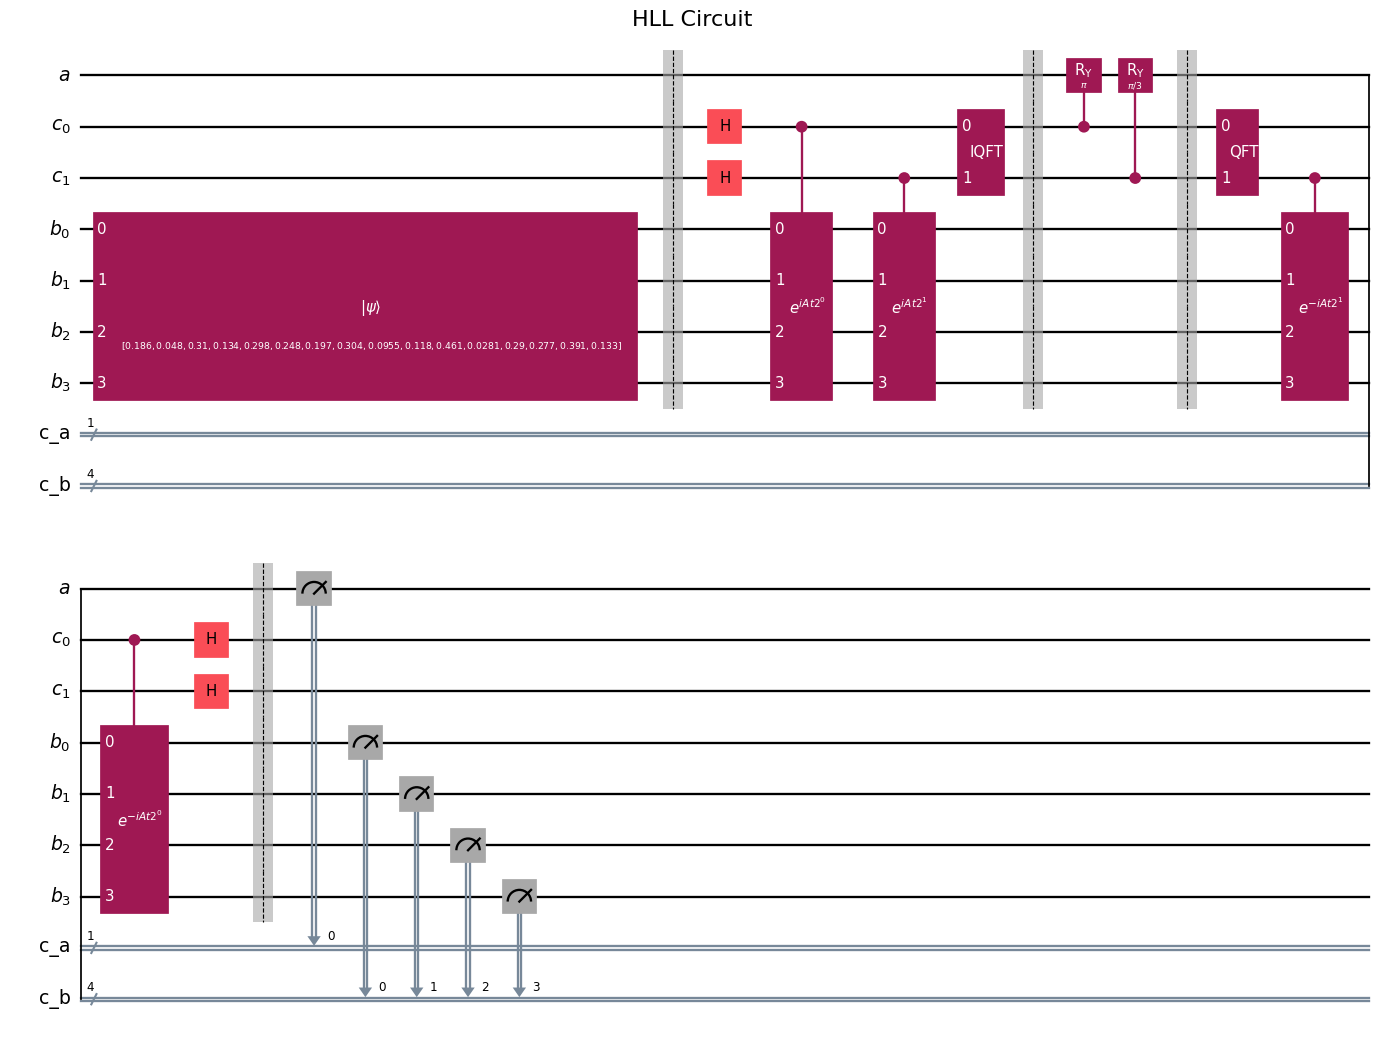

In [ ]:
A, b = sample_generator(N=16)
hll_solver = HLLSolver(A,b, c=2,C=1)
hll_solver.build(detailed=True)
hll_solver.plot_circuit()

### Analysis in general scenario

We check that the stats generation is correct for the example circuit

In [ ]:
retreive_info(hll_solver.qc)

{'total_gates': 2759,
 'gate_counts': {'u': 1777, 'cx': 969, 'measure': 5, 'reset': 4, 'barrier': 4},
 'depth': 1901,
 'num_qubits': 7}

Now we will go through different values of $N$ and we will get the stats about the circuit counting.

In [ ]:
%%time
records = []
values = range(1, 7)
for i in values:
    N = 2**i
    for i in range(10):
      A, b = sample_generator(N)
      hll_solver = HLLSolver(A, b, c=2, C=1).build(detailed=False)
      r = retreive_info(hll_solver.qc)
      r["N"] = N
      r["shot"] = i
      records.append(r)
    print(f'Built for N={N}')
df = pd.DataFrame(records)
df

Built for N=2
Built for N=4
Built for N=8
Built for N=16
Built for N=32
Built for N=64
CPU times: user 14min 27s, sys: 4.85 s, total: 14min 32s
Wall time: 14min 27s


,total_gates,gate_counts,depth,num_qubits,N,shot
0,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,0
1,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,1
2,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,2
3,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,3
4,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,4
5,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,5
6,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,6
7,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,7
8,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,8
9,72,"{'u': 43, 'cx': 22, 'barrier': 4, 'measure': 2...",51,4,2,9


In [ ]:
cols = ['total_gates','depth','N']
df_mean = df[cols].groupby('N').mean()
df_mean

,total_gates,depth
N,,
2,72.0,51.0
4,165.0,102.0
8,654.0,427.8
16,2749.4,1897.8
32,11364.0,8009.4
64,46246.6,32905.0


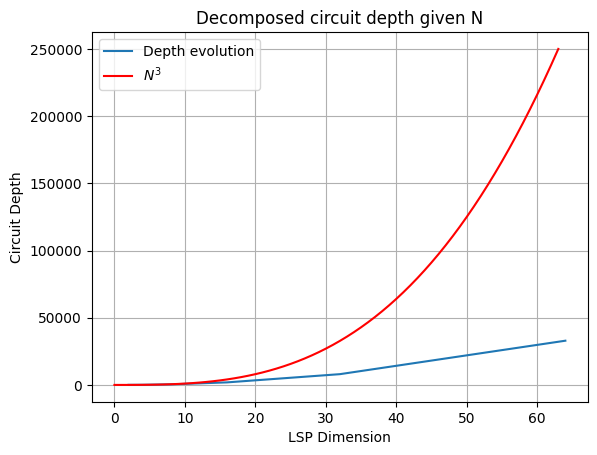

In [ ]:
plt.plot(df_mean.index, df_mean['depth'],label='Depth evolution')
plt.plot(range(0, 2**6),np.array(range(0, 2**6))** 3, color = 'red', label = '$N^3$')
plt.title('Decomposed circuit depth given N')
plt.xlabel('LSP Dimension')
plt.ylabel('Circuit Depth')
plt.grid()
plt.legend()
plt.show()

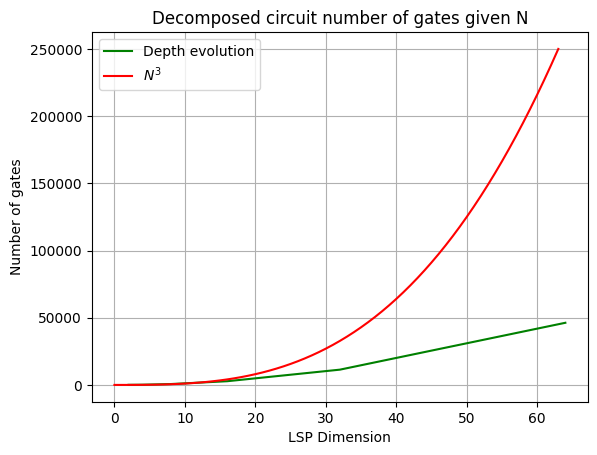

In [ ]:
plt.plot(df_mean.index, df_mean['total_gates'],label='Depth evolution', color='green')
plt.plot(range(0, 2**6),np.array(range(0, 2**6))** 3, color = 'red', label = '$N^3$')
plt.title('Decomposed circuit number of gates given N')
plt.xlabel('LSP Dimension')
plt.ylabel('Number of gates')
plt.grid()
plt.legend()
plt.show()

### Analysis in transpiled scenario

We will get the stats from that circuit simulating the decomposition in a real IBM computer

In [ ]:
backend = build_generic_ibm_backend(hll_solver.qc.num_qubits)
transpile_to_hardware(hll_solver.qc, backend=backend)

{'total_gates': 298738,
 'gate_counts': {'rz': 163555,
  'sx': 92569,
  'cx': 42596,
  'measure': 7,
  'reset': 6,
  'barrier': 4,
  'x': 1},
 'depth': 163559,
 'num_qubits': 9}

Now we will go through different values of $N$ and we will get the stats about the circuit counting.

In [ ]:
%%time
records = []
values = range(1, 7)
for i in values:
    N = 2**i
    for i in range(10):
      A, b = sample_generator(N)
      hll_solver = HLLSolver(A, b, c=2, C=1).build(detailed=False)
      backend = build_generic_ibm_backend(hll_solver.qc.num_qubits)
      r = transpile_to_hardware(
          hll_solver.qc,
          backend=backend
      )
      r["N"] = N
      r["shot"] = i
      records.append(r)
    print(f'Built for N={N}')
df = pd.DataFrame(records)
df

Built for N=2
Built for N=4
Built for N=8
Built for N=16
Built for N=32
Built for N=64
CPU times: user 10min 27s, sys: 3.53 s, total: 10min 30s
Wall time: 10min


,total_gates,gate_counts,depth,num_qubits,N,shot
0,232,"{'rz': 121, 'sx': 69, 'cx': 31, 'barrier': 4, ...",152,4,2,0
1,248,"{'rz': 132, 'sx': 77, 'cx': 31, 'barrier': 4, ...",154,4,2,1
2,232,"{'rz': 121, 'sx': 69, 'cx': 31, 'barrier': 4, ...",152,4,2,2
3,228,"{'rz': 119, 'sx': 69, 'cx': 31, 'barrier': 4, ...",155,4,2,3
4,231,"{'rz': 120, 'sx': 69, 'cx': 31, 'barrier': 4, ...",152,4,2,4
5,248,"{'rz': 132, 'sx': 77, 'cx': 31, 'barrier': 4, ...",155,4,2,5
6,248,"{'rz': 132, 'sx': 77, 'cx': 31, 'barrier': 4, ...",154,4,2,6
7,228,"{'rz': 119, 'sx': 69, 'cx': 31, 'barrier': 4, ...",155,4,2,7
8,244,"{'rz': 129, 'sx': 75, 'cx': 31, 'barrier': 4, ...",153,4,2,8
9,243,"{'rz': 128, 'sx': 75, 'cx': 31, 'barrier': 4, ...",152,4,2,9


In [ ]:
cols = ['total_gates','depth','N']
df_mean = df[cols].groupby('N').mean()
df_mean

,total_gates,depth
N,,
2,238.2,153.4
4,659.3,359.3
8,3498.8,1978.3
16,16058.2,9180.1
32,68882.6,39120.4
64,278095.1,159394.1


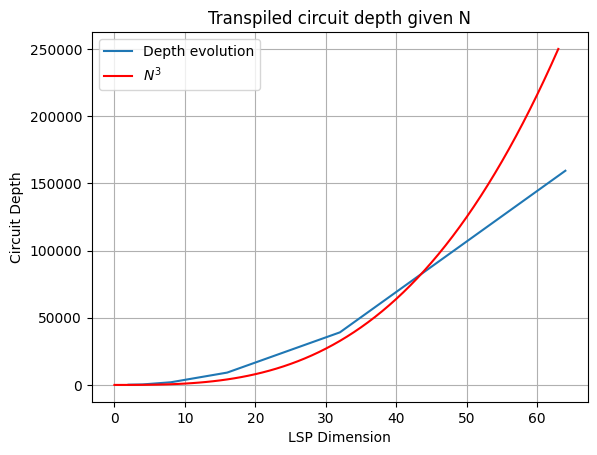

In [ ]:
plt.plot(df_mean.index, df_mean['depth'],label='Depth evolution')
plt.plot(range(0, 2**6),np.array(range(0, 2**6))** 3, color = 'red', label = '$N^3$')
plt.title('Transpiled circuit depth given N')
plt.xlabel('LSP Dimension')
plt.ylabel('Circuit Depth')
plt.grid()
plt.legend()
plt.show()

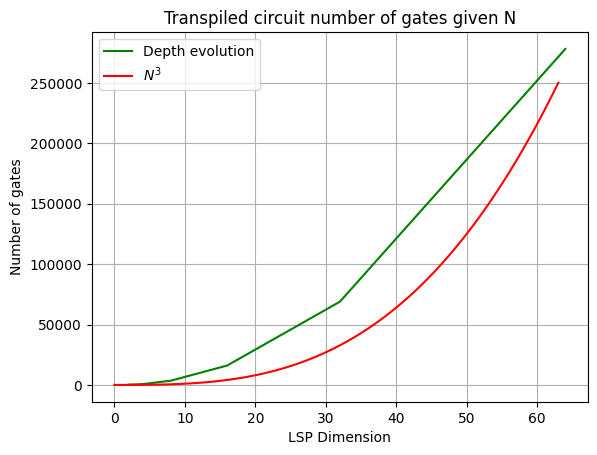

In [ ]:
plt.plot(df_mean.index, df_mean['total_gates'],label='Depth evolution', color='green')
plt.plot(range(0, 2**6),np.array(range(0, 2**6))** 3, color = 'red', label = '$N^3$')
plt.title('Transpiled circuit number of gates given N')
plt.xlabel('LSP Dimension')
plt.ylabel('Number of gates')
plt.grid()
plt.legend()
plt.show()

## Working in the NISQ era

As part of our analysis task, we would like to see nowadays how can we apply this algorithm in a real IBM QPU. For this, we will use the 2x2 example.

In [ ]:
service = QiskitRuntimeService(token="YOUR API KEY")            #Here insert you IBM Api-token
                                                                #(Take into account the prices related)
                                                                #Results shown was done with an account
                                                                #Its key is not provided here for security
backend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qiskit_runtime_service._discover_account:WARNING:2025-12-14 02:23:45,787: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2025-12-14 02:23:48,990: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: main_instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-14 02:23:49,517: Loading instance: main_instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-14 02:23:51,650: Using instance: main_instance, plan: open


Now we build our circuit

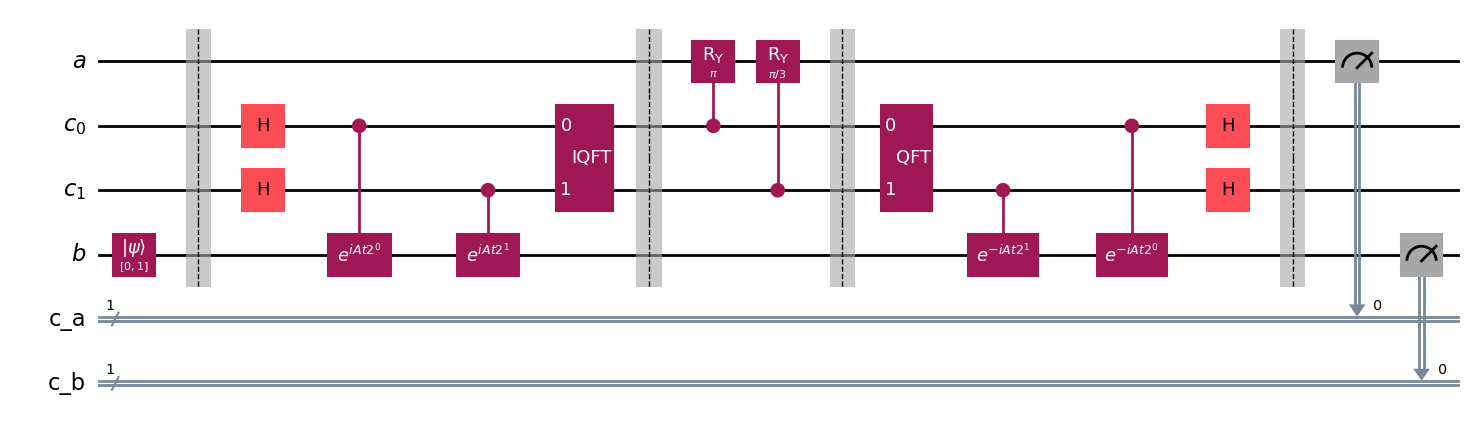

In [ ]:
A = np.array([
    [1, -1/3],
    [-1/3, 1]
])
b = np.array([0,1])
c = 2
C = 1

hll_solver = HLLSolver(A,b,c,C)
hll_solver.build(detailed=True)
qc = hll_solver.qc
qc.draw('mpl')

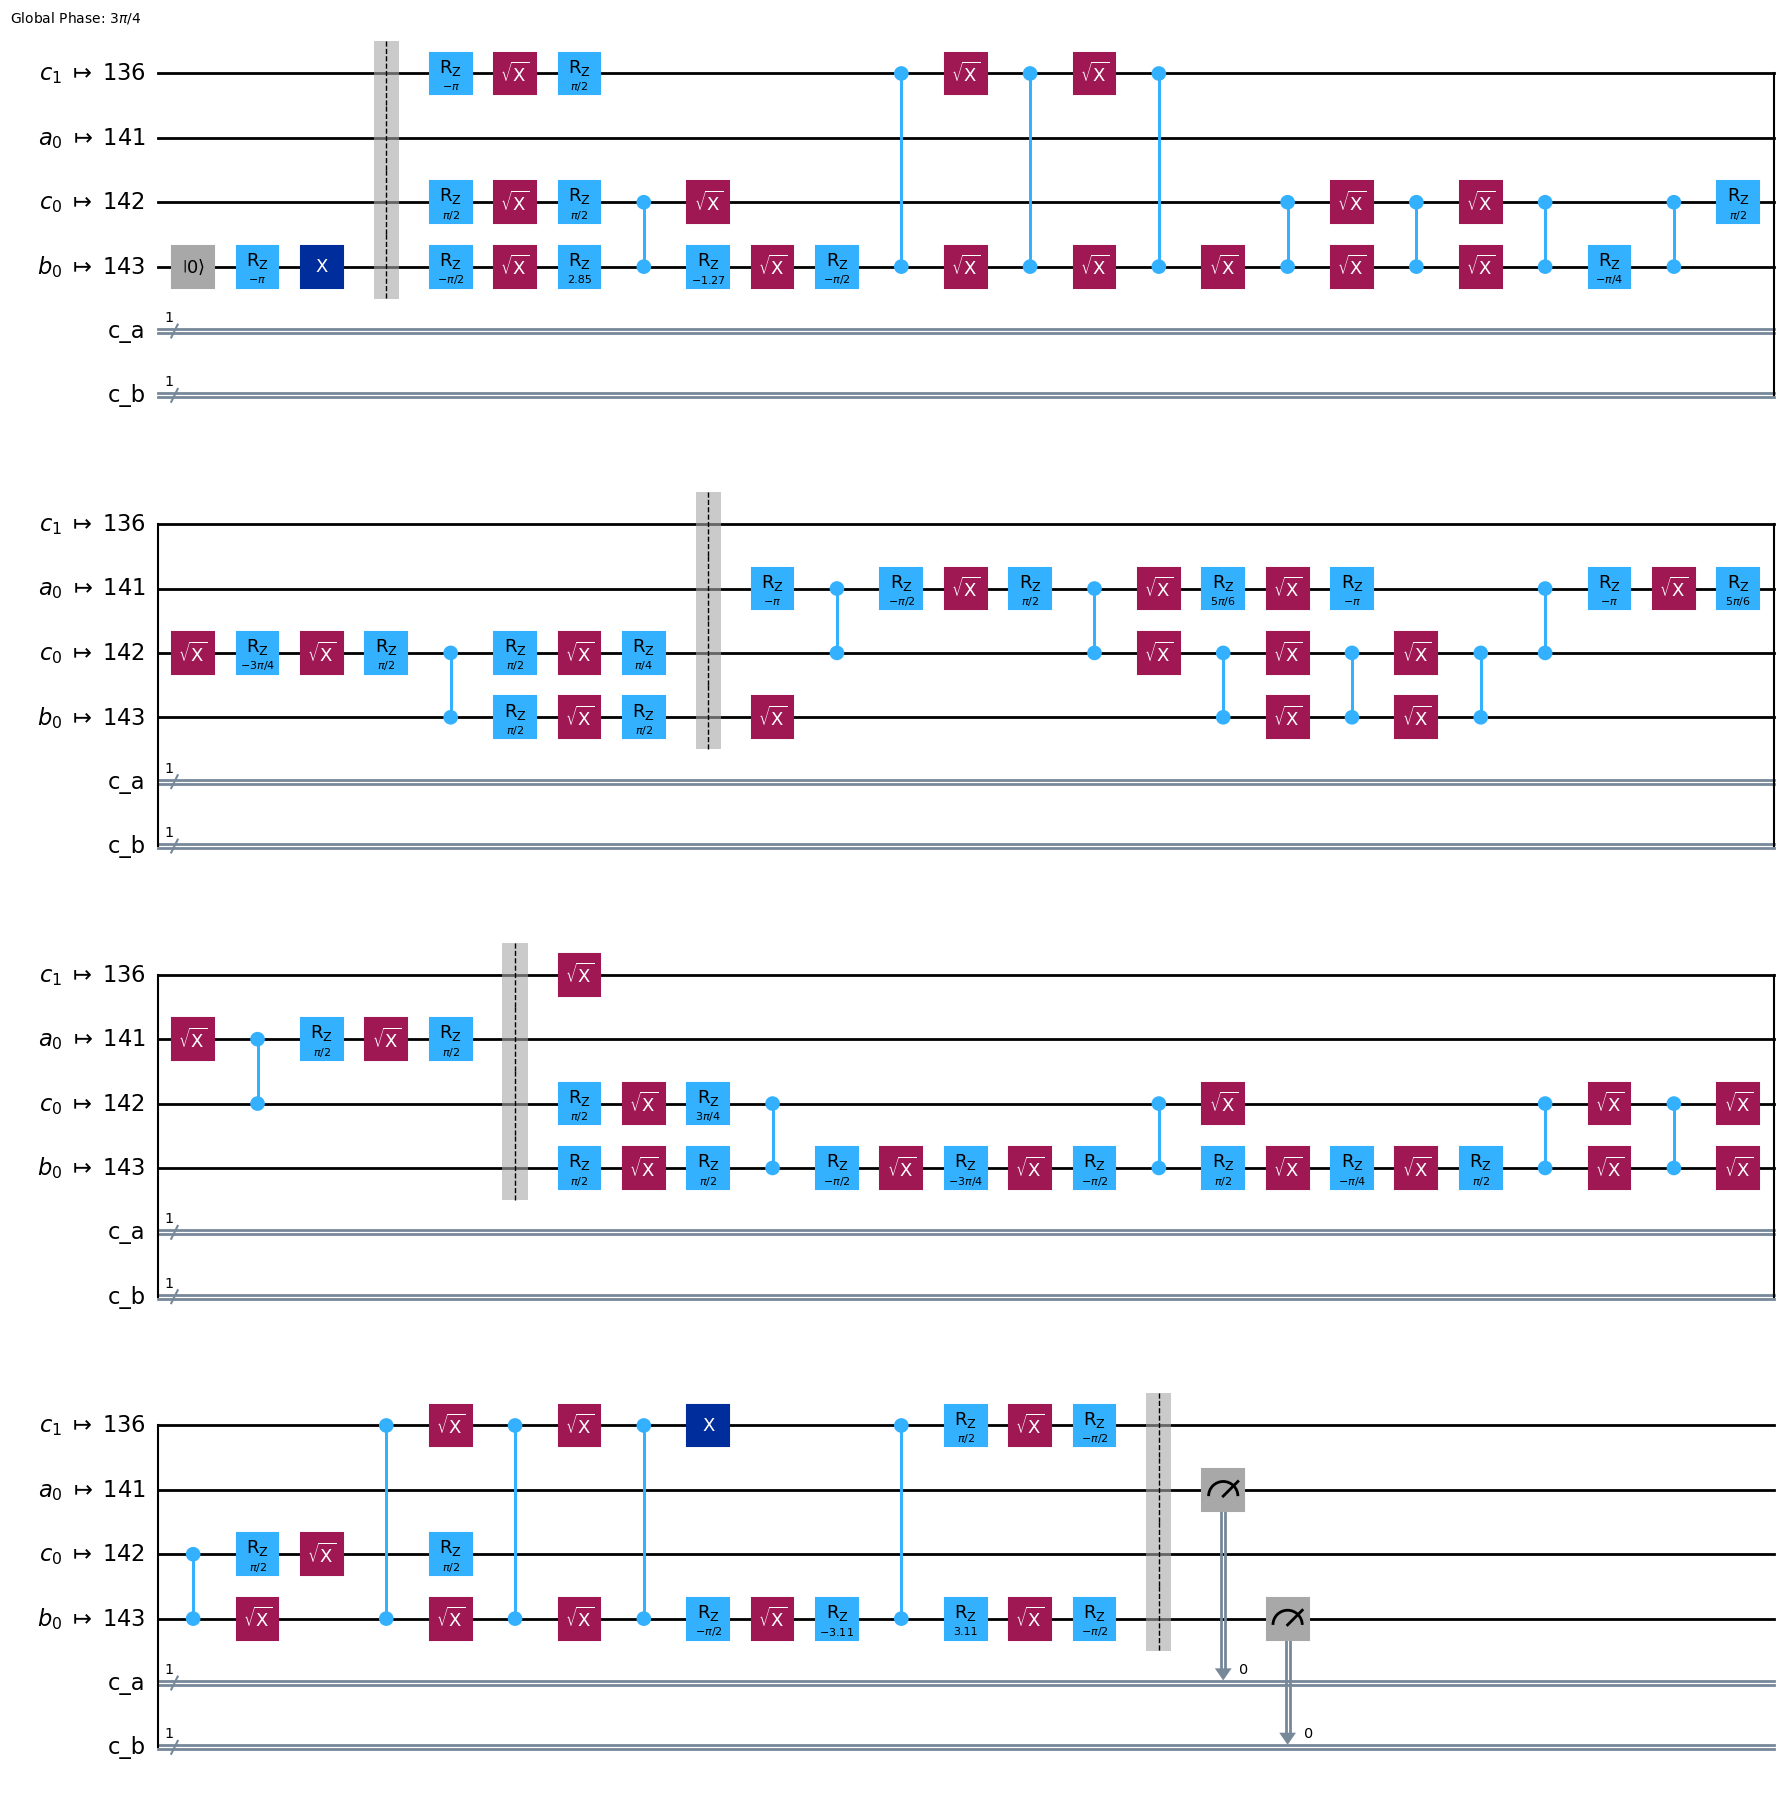

In [ ]:
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

Now we execute our circuit and wait for the results

In [ ]:
sampler = Sampler(mode=backend)
job = sampler.run([(isa_circuit, )], shots=1024)
result = job.result()
data = result[0].data
bits_a = data['c_a'].to_bool_array().astype(int).flatten()
bits_b = data['c_b'].to_bool_array().astype(int).flatten()
joint_counts = Counter(
    f"{b} {a}" for a, b in zip(bits_a, bits_b)
)
print(joint_counts)

Counter({'1 0': 805, '0 1': 80, '1 1': 74, '0 0': 65})


We define a simpler HLL experiment overloading it in order to look at the results

In [ ]:
class HLLExperimentLoaded(HLLExperiment):
    def __init__(self, data, qc):
        super().__init__(qc)
        self.counts = data

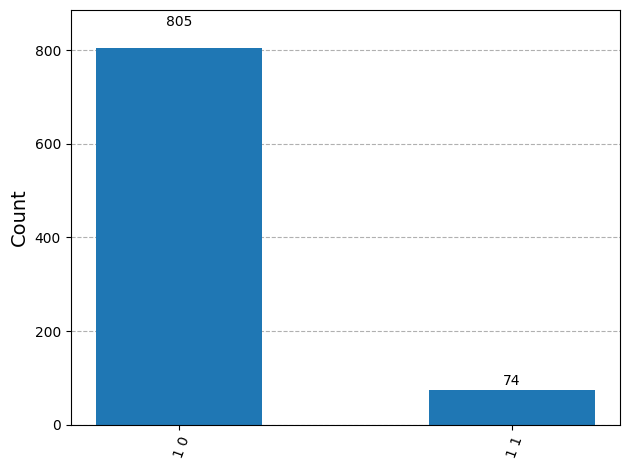

Simulated result = [0.29014923 0.95698141]


In [ ]:
r = HLLExperimentLoaded(joint_counts, qc)
r.filter_ancilla().plot()
v = r.retreive_answer()
print(f'Simulated result = {v}')

In [ ]:
print(f'Relationship = {v / np.min(v)}')

Relationship = [1.         3.29823868]


This is the report given by IBM Cloud provider

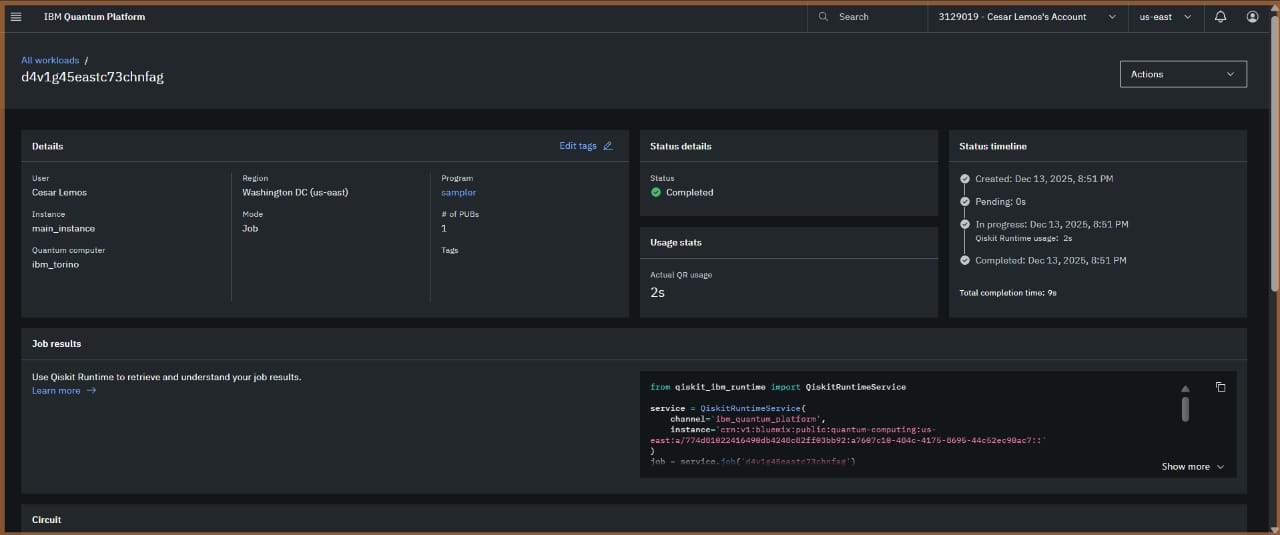

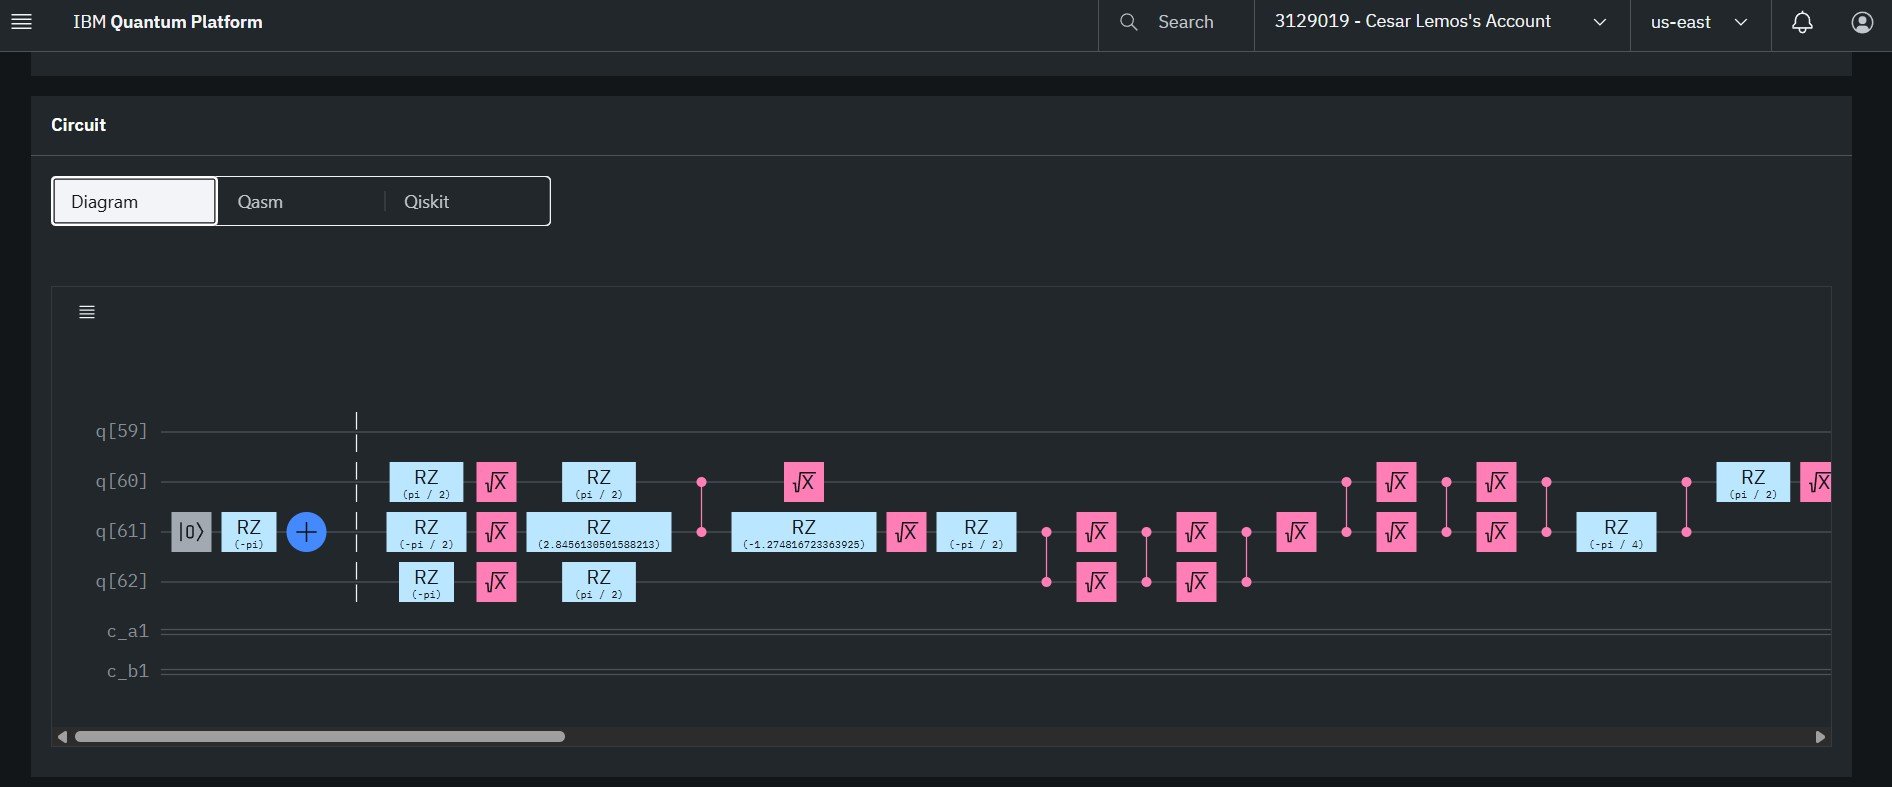

Process took near to 2 seconds of QPU to compute 1024 shots of the $2 \times 2$ example.

## Conclusions


- **Object-Oriented Programming for Quantum Algorithm Design**  
  The notebook shows that adopting an object-oriented programming (OOP) paradigm is highly effective for implementing quantum algorithms such as HHL. By structuring the code into classes that represent the main algorithmic components (state preparation, QPE, controlled rotations, inverse QPE, and measurement), the implementation closely follows the theoretical decomposition of the algorithm. This modular design improves readability, facilitates debugging and validation, and enables systematic experimentation with different parameters and circuit variants, which is essential for both research and educational purposes.

- **Practical Complexity and Evidence of Improved Scaling over $N^3$**  
  Through the empirical metrics collected in the notebook—such as circuit depth, gate counts, and execution statistics—the HLL/HHL implementation exhibits a practical scaling that is more favorable than the classical $ \mathcal{O}(N^3) $ complexity of direct linear solvers. By focusing on measurement strategies that extract relevant information (e.g., success probabilities and expectation values) instead of reconstructing the full solution vector, the results demonstrate how quantum linear solvers can bypass classical bottlenecks in practice, even on near-term hardware.

- **Execution of HHL-Type Circuits in the NISQ Era**  
  The experiments confirm that, despite their depth and sensitivity to noise, HHL-type circuits can already be executed in the NISQ era using current simulators and hardware-oriented backends. In the presented examples, the obtained results are consistent with theoretical expectations and remain stable under realistic noise and hardware constraints. This indicates that quantum linear solvers are not purely theoretical constructs, but viable testbeds for benchmarking and exploring quantum advantage on today’s quantum devices.

- **Impact of Transpilation on Realistic Complexity Analysis**  
  The notebook highlights that transpilation is a critical factor in any practical complexity analysis. Hardware constraints such as qubit connectivity, native gate sets, and optimization levels significantly alter circuit depth and two-qubit gate counts after transpilation. As a result, theoretical (logical) complexity estimates must be complemented with transpiled metrics to obtain a realistic picture of performance in the NISQ era. Ignoring transpilation effects can lead to misleading conclusions about scalability and feasibility on real quantum hardware.

- **Precision Considerations in the HLL Algorithm**  
  The notebook emphasizes that precision plays a central role in the practical performance of the HLL algorithm. The number of qubits allocated to the phase estimation and reciprocal approximation registers directly determines the resolution with which eigenvalues are encoded and inverted. Increasing precision improves the fidelity of the solution but leads to deeper circuits, higher gate counts, and increased sensitivity to noise—an especially critical trade-off in the NISQ era. The experiments illustrate that carefully chosen, problem-dependent precision levels can achieve a balance between accuracy and hardware feasibility, yielding reliable results without incurring the prohibitive costs associated with unnecessarily high precision.



## References


[1] A. W. Harrow, A. Hassidim, and S. Lloyd, *Quantum algorithm for linear systems of equations*, **Physical Review Letters**, vol. 103, 2009.

[2] A. Zaman, H. J. Morrell, and H. Y. Wong, *A step-by-step HHL algorithm walkthrough to enhance understanding of critical quantum computing concepts*, **IEEE Access**, vol. 11, 2023.

[3] A. Zaman *et al.*, *A step-by-step HHL algorithm walkthrough*, **IEEE Access**, 2023.

[4] M. A. Nielsen and I. L. Chuang, *Quantum Computation and Quantum Information*, Cambridge University Press, 2010.
